# DLO-JZ Optimiseurs et large batch - Jour 2 

Les cellules dans ce *notebook* ne sont pas prévues pour être modifiées, sauf rares exceptions indiquées dans les commentaires. 

*Notebook rédigé par l'équipe assistance IA de l'IDRIS, octobre 2022*


------------------------

Ce notebook est prévu pour être exécuté à partir d'une machine frontale de Jean-Zay. Le *hostname* doit être jean-zay[1-5].

In [1]:
!hostname

jean-zay-srv2


Un module PyTorch doit avoir été chargé pour le bon fonctionnement de ce Notebook. **Nécessairement**, le module `pytorch-gpu/py3/1.11.0` :

In [2]:
!module list

Currently Loaded Modulefiles:
 1) cuda/11.2                5) openmpi/4.1.1-cuda   9) sparsehash/2.0.3        
 2) nccl/2.9.6-1-cuda        6) intel-mkl/2020.4    10) libjpeg-turbo/2.1.3     
 3) cudnn/8.1.1.33-cuda      7) magma/2.5.4-cuda    11) pytorch-gpu/py3/1.11.0  
 4) gcc/8.5.0(8.3.1:8.4.1)   8) sox/14.4.2          
>

Les fonctions *python* de gestion de queue SLURM dévelopées par l'IDRIS et les fonctions dédiées à la formation DLO-JZ sont à importer.

Le module d'environnement pour les *jobs* et la taille des images sont fixés pour ce *notebook*.

**TODO :** choisir un *pseudonyme* (maximum 5 caractères) pour vous différencier dans la queue SLURM et dans les outils collaboratifs pendant la formation et la compétition.

In [3]:
from idr_pytools import display_slurm_queue, gpu_jobs_submitter, search_log
from dlojz_tools_tp import plot_accuracy, lrfind_plot, plot_accuracy_lr
MODULE = 'pytorch-gpu/py3/1.11.0'
account = 'sos@v100'
n_gpu = 2

name = 'solution'  #TODO#

------------------------------------

## Dataset et modèle

Pour ce TP, on va utiliser la base de données CIFAR 10 et le modèle Resnet-18 pour pouvoir faire tourner des entrainements complets en un temps raisonnable. Le TP se fera en modifiant le code `cifar10.py`.

### CIFAR 10

#### Train set

In [4]:
import os
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([ 
        transforms.RandomHorizontalFlip(),              # Horizontal Flip - Data Augmentation
        transforms.ToTensor()                          # convert the PIL Image to a tensor
        ])
    
    
train_dataset = torchvision.datasets.CIFAR10(root=os.environ['ALL_CCFRSCRATCH']+'/CIFAR_10',
                                             train=True, download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,    
                                           batch_size=4,
                                           shuffle=True)
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /gpfsscratch/rech/ibu/commun/CIFAR_10
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

X train batch, shape: torch.Size([4, 3, 32, 32]), data type: torch.float32, Memory usage: 49152 bytes
Y train batch, shape: torch.Size([4]), data type: torch.int64, Memory usage: 32 bytes


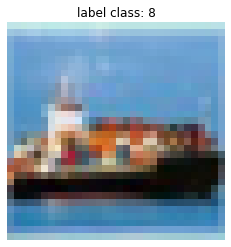

In [5]:
batch = next(iter(train_loader))
print('X train batch, shape: {}, data type: {}, Memory usage: {} bytes'
      .format(batch[0].shape, batch[0].dtype, batch[0].element_size()*batch[0].nelement()))
print('Y train batch, shape: {}, data type: {}, Memory usage: {} bytes'
      .format(batch[1].shape, batch[1].dtype, batch[1].element_size()*batch[1].nelement()))

img = batch[0][0].numpy().transpose((1,2,0))
plt.imshow(img)
plt.axis('off')
_ = plt.title('label class: {}'.format(batch[1][0].numpy()))

#### Validation set

In [6]:
val_transform = transforms.Compose([
                    transforms.ToTensor()                           # convert the PIL Image to a tensor
                    ])
    
val_dataset = torchvision.datasets.CIFAR10(root=os.environ['ALL_CCFRSCRATCH']+'/CIFAR_10',
                                               train=False, download=False, transform=val_transform)
val_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /gpfsscratch/rech/ibu/commun/CIFAR_10
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

### Resnet-18

In [7]:
model = models.resnet18()
print('number of total parameters: {}'.format(sum([p.numel() for p in model.parameters()])))
print('number of trainable parameters: {}'.format(sum([p.numel() for p in model.parameters() if p.requires_grad])))

number of total parameters: 11689512
number of trainable parameters: 11689512


-----------

## Description

Nous étudierons 4 *optimizer* (SGD, AdamW, LAMB et LARS).

A chaque fois nous regarderons le cas d'un apprentissage **Small Batch** et le cas d'un apprentissage **Large Batch**.

 * **Small Batch** : *Global Batch Size* de **256** sur 2 GPU sur **30** *epochs*
 * **Large Batch** : *Global Batch Size* de **8192** sur 2 GPU sur **50** *epochs* 


**Remarque** : 

Le paramètre *wrapped_optimizer* est présent dans le code à cause de l'implémentation de LARS spécifiquement. Car le *LR scheduler* doit prendre en entrée l'*optimizer SGD* de base non *wrapped*. 

Pour les autres *optimizers*, il ne sert à rien. Mais cette astuce permet de basculer sur chaque type d'*optimizer* facilement. 

------------------------------------

## LR Finder

Dans le but d'utiliser un *Cycle Scheduler*, il nous faut d'abord trouver l'intervalle des valeurs du *learning rate* qui auront un effet positif sur l'apprentissage du modèle.

On va lancer le script 'cifar10.py' avec l'option `--findlr` ce qui va lancer l'entrainement sur quelques *epochs* durant lesquelles le *learning rate* va doucement augmenter.

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

In [8]:
command = [f'cifar10.py -b 128 -e 10 --findlr --lr 5.', 
           f'cifar10.py -b 4096 -e 20 --findlr --lr 5.']
jobid_sgd_lrf = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_sgd_lrf = {jobid_sgd_lrf}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 10 cpus per task
Submitted batch job 228509
Submitted batch job 228510
jobid_sgd_lrf = ['228509', '228510']


In [9]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            228479   gpu_p13 solution  ssos023  R       2:45      1 r10i2n3

 Done!


In [10]:
#jobid_sgd_lrf = ['392317', '392318']

Vous pouvez maintenant tracer la courbe de la *loss* en fonction du *learning rate*.

#### Small Batch

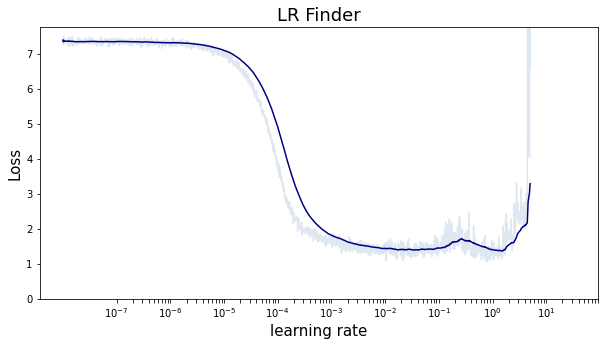

In [11]:
lrfind_plot(jobid_sgd_lrf[:1])

La courbe transparente représente les valeurs réelles, la courbe opaque représente un lissage de ces valeurs.

À partir de cette courbe, vous pouvez trouver les valeurs minimale et maximale acceptables du *learning rate*.

#### Large Batch

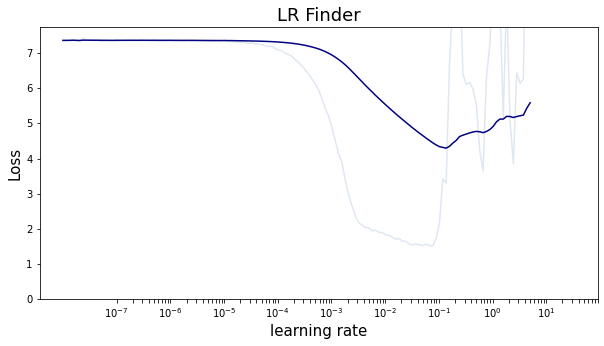

In [12]:
lrfind_plot(jobid_sgd_lrf[1:])

------------------------------------

## TP_opti_0 : *Learning Rate* constant (référence)

On va lancer un entrainement de référence avec un *learning rate* constant.

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

**TODO : remplacer XXX par la valeur de *learning rate* choisie**

In [13]:
lr = 0.1
command = f'cifar10.py -b 128 -e 30 --wd 5e-3 --lr {lr}'
jobid1 = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid1 = {jobid1}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 10 cpus per task
Submitted batch job 228535
jobid1 = ['228535']


In [14]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            228535   gpu_p13 solution  ssos023  R       2:19      1 r10i1n6

 Done!


In [15]:
#jobid1 = ['392353']

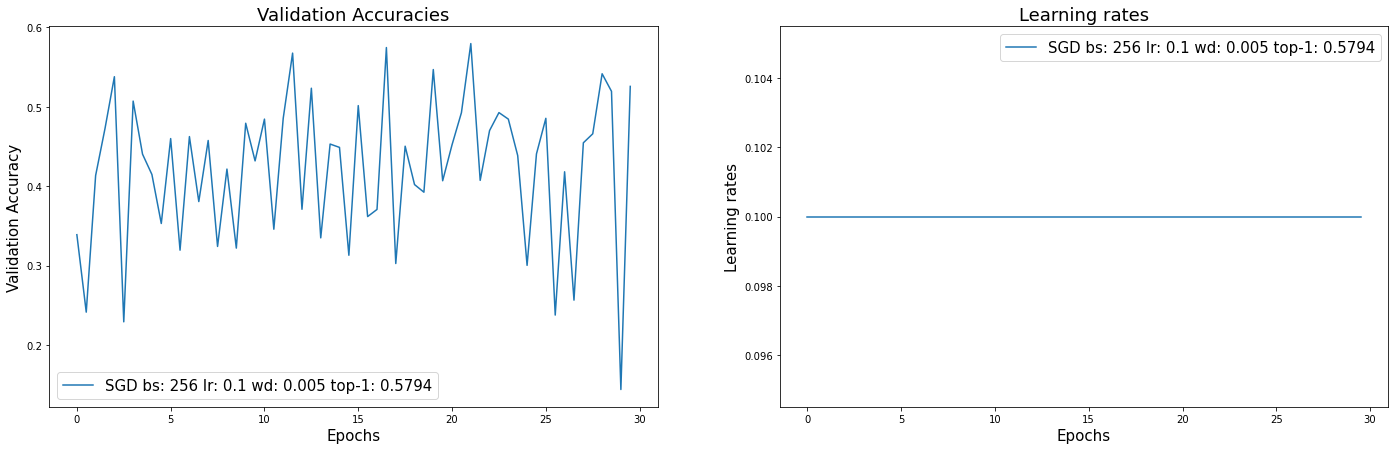

Resnet-18: SGD bs: 256 lr: 0.1 wd: 0.005 top-1: 0.5794 >>> Training complete in: 0:02:10.685908


In [16]:
jobids=[jobid1]
plot_accuracy_lr(jobids)

## TP_opti_1 : *One Cycle Learning Rate*

Nous allons maintenant modifier le code pour remplacer le *learning rate* constant par un *One Cycle Scheduler* et comparer le résultat avec l'entrainement de référence.

**TODO** : dans le script `cifar10.py`:
* Trouver la ligne de déclaration du *Learning Rate Scheduler* :

```python
scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1, total_iters=5)
```
* Le remplacer par un *One Cycle Scheduler* 

```python
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.lr, steps_per_epoch=N_batch, epochs=args.epochs)
```

__Remarque__ : Le *OneCycleLR* de PyTorch calcule automatiquement une valeur minimale de *learning rate* à partir de la valeur maximale donnée.

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

**TODO : remplacer XXX par les valeurs maximales de *learning rate* choisies (Small Batch et Large Batch)**

In [17]:
lr_smallb = 0.1
lr_largeb = 0.1
command = [f'cifar10.py -b 128 -e 30 --wd 5e-3 --lr {lr_smallb}', 
           f'cifar10.py -b 4096 -e 50 --wd 5e-3 --lr {lr_largeb}']
jobid_sgd = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_sgd = {jobid_sgd}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 10 cpus per task
Submitted batch job 228548
Submitted batch job 228549
jobid_sgd = ['228548', '228549']


In [18]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            228548   gpu_p13 solution  ssos023  R       2:20      1 r10i1n6

 Done!


In [19]:
#jobid_sgd = ['392386', '392388']

Vous pouvez comparer les courbes de *test accuracy* et de *learning rate* avec l'entrainement de référence.

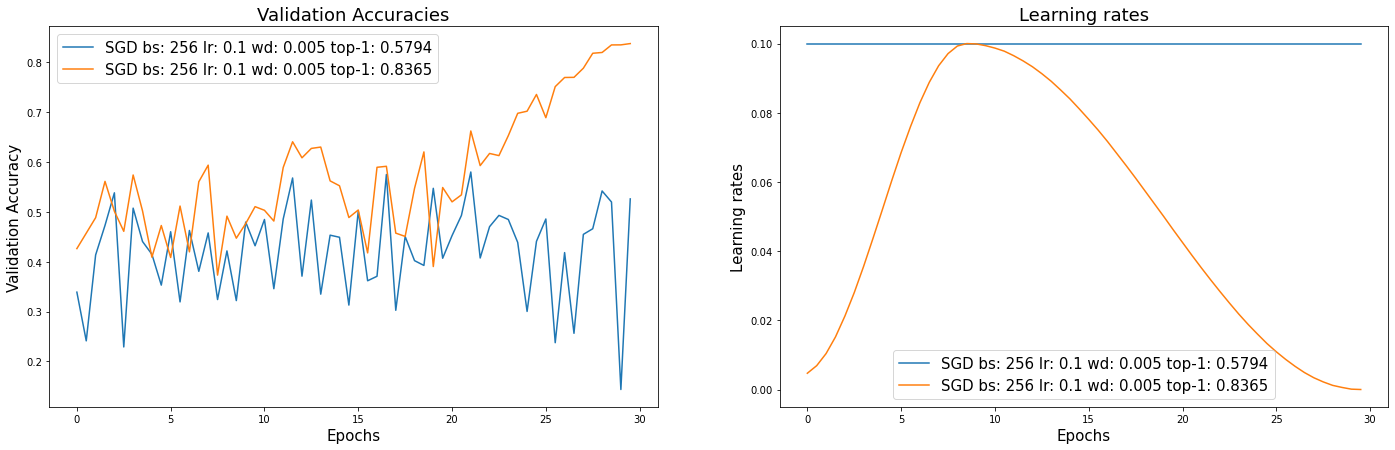

Resnet-18: SGD bs: 256 lr: 0.1 wd: 0.005 top-1: 0.5794 >>> Training complete in: 0:02:10.685908
Resnet-18: SGD bs: 256 lr: 0.1 wd: 0.005 top-1: 0.8365 >>> Training complete in: 0:02:10.606692


In [20]:
jobids=[jobid1, jobid_sgd[:1]]
plot_accuracy_lr(jobids)

------------------------------------

## TP_opti_2 : Optimiseur *AdamW*

On va maintenant modifier l'optimiseur pour utiliser *AdamW*.

**TODO** : dans le script `cifar10.py`:
* Trouver la ligne de déclaration de l'optimiseur *Stochastic Gradient Descent* :

```python
optimizer = torch.optim.SGD(model.parameters(), args.lr, momentum=args.mom, weight_decay=args.wd)
```
* Le remplacer par l'optimiseur *Adam* :

```python
optimizer = torch.optim.AdamW(model.parameters(), args.lr, betas=(args.mom, 0.999), weight_decay=args.wd)
```

L'optimiseur ayant changé il nous faut recalculer la valeur de *learning rate* maximale à donner en paramètre :

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.


In [21]:
command = [f'cifar10.py -b 128 -e 10 --findlr --lr 5.', 
           f'cifar10.py -b 4096 -e 20 --findlr --lr 5.']
jobid_adam_lrf = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_adam_lrf = {jobid_adam_lrf}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 10 cpus per task
Submitted batch job 228561
Submitted batch job 228562
jobid_adam_lrf = ['228561', '228562']


In [22]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            228561   gpu_p13 solution  ssos023  R       0:51      1 r10i1n6

 Done!


In [23]:
#jobid_adam_lrf = ['392485', '392486']

#### Small batch

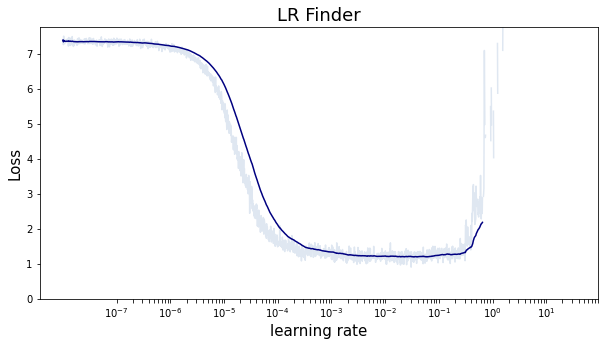

In [24]:
lrfind_plot(jobid_adam_lrf[:1])

#### Large batch

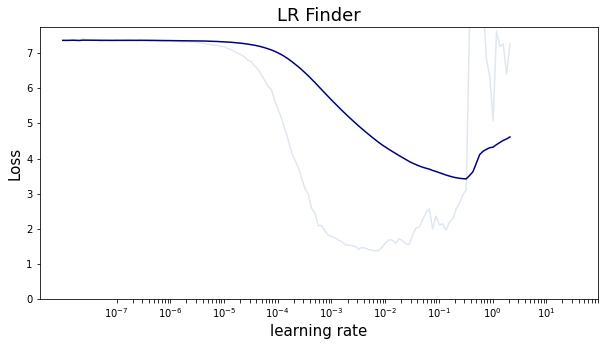

In [25]:
lrfind_plot(jobid_adam_lrf[1:])

Vous pouvez maintenant lancer l'entrainement avec l'optimiseur *AdamW*.

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

**TODO : remplacer XXX par les valeurs maximales de *learning rate* choisies (Small Batch et Large Batch)**

In [26]:
lr_smallb = 0.1
lr_largeb = 0.1
command = [f'cifar10.py -b 128 -e 30 --wd 1e-2 --lr {lr_smallb}', 
           f'cifar10.py -b 4096 -e 50 --wd 1e-2 --lr {lr_largeb}']
jobid_adamw = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_adamw = {jobid_adamw}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 10 cpus per task
Submitted batch job 228564
Submitted batch job 228565
jobid_adamw = ['228564', '228565']


In [27]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            228564   gpu_p13 solution  ssos023  R       2:37      1 r10i1n6

 Done!


In [28]:
#jobid_adamw = ['392515', '392516']

Vous pouvez comparer les courbes de *test accuracy* et de *train accuracy* avec les entrainements précédents.

#### Small batch

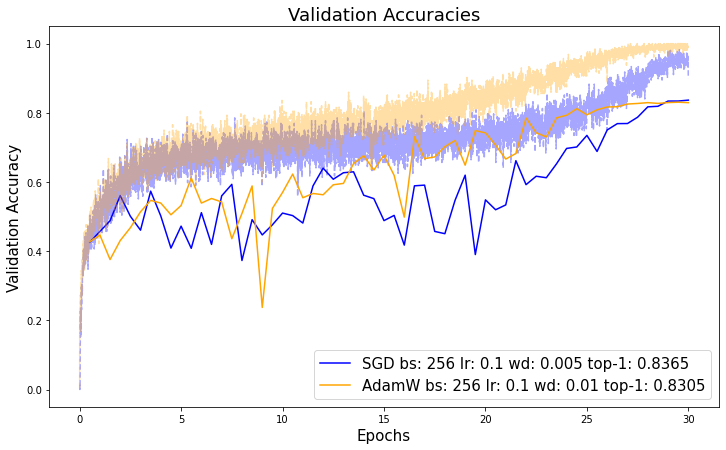

Resnet-18: SGD bs: 256 lr: 0.1 wd: 0.005 top-1: 0.8365 >>> Training complete in: 0:02:10.606692
Resnet-18: AdamW bs: 256 lr: 0.1 wd: 0.01 top-1: 0.8305 >>> Training complete in: 0:02:31.214266


In [29]:
jobids=[jobid_sgd[:1], jobid_adamw[:1]]
plot_accuracy(jobids)

#### Large batch

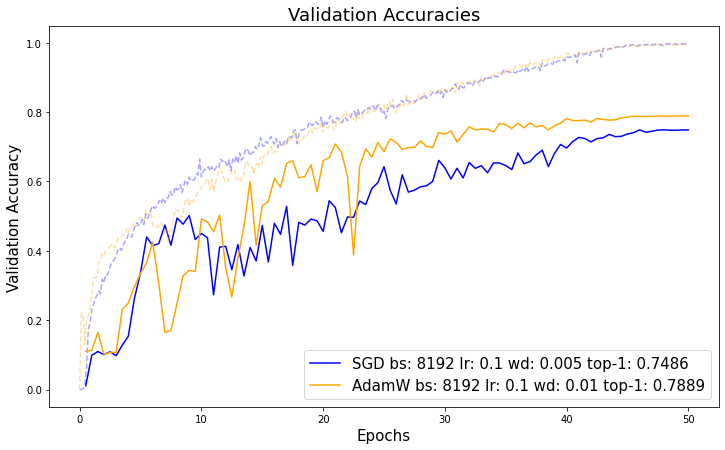

Resnet-18: SGD bs: 8192 lr: 0.1 wd: 0.005 top-1: 0.7486 >>> Training complete in: 0:01:30.652120
Resnet-18: AdamW bs: 8192 lr: 0.1 wd: 0.01 top-1: 0.7889 >>> Training complete in: 0:01:31.498707


In [30]:
jobids=[jobid_sgd[1:], jobid_adamw[1:]]
plot_accuracy(jobids)

------------------------------------

## TP_opti_3 : Optimiseur *LAMB*

On va maintenant modifier l'optimiseur pour utiliser *LAMB*.

**TODO** : dans le script `cifar10.py`:
* Remplacer l'optimiseur *AdamW* par l'optimiseur *LAMB* :

```python
optimizer = apex.optimizers.FusedLAMB(model.parameters(), args.lr, betas=(args.mom, 0.999), weight_decay=args.wd)
```

Il faut maintenant à nouveau toruver la valeur de *learning rate* maximale à donner en paramètre pour cet optimiseur :

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

In [31]:
command = [f'cifar10.py -b 128 -e 10 --findlr --lr 5.', 
           f'cifar10.py -b 4096 -e 20 --findlr --lr 5.']
jobid_lamb_lrf = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_lamb_lrf = {jobid_lamb_lrf}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 10 cpus per task
Submitted batch job 228608
Submitted batch job 228609
jobid_lamb_lrf = ['228608', '228609']


In [32]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            228609   gpu_p13 solution  ssos023  R       0:40      1 r10i2n3

 Done!


In [33]:
#jobid_lamb_lrf = ['392536', '392537']

#### Small Batch

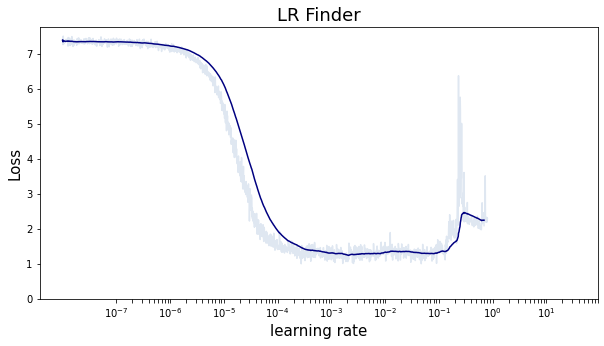

In [34]:
lrfind_plot(jobid_lamb_lrf[:1])

#### Large Batch

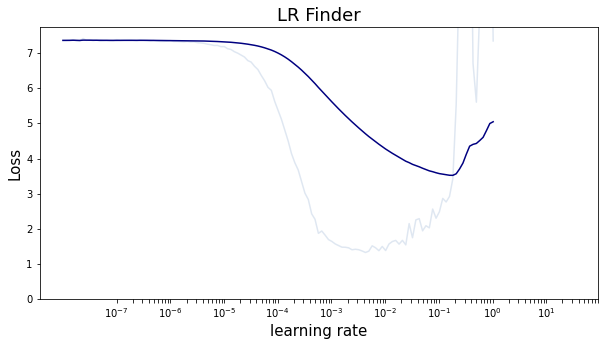

In [35]:
lrfind_plot(jobid_lamb_lrf[1:])

Vous pouvez maintenant lancer l'entrainement avec l'optimiseur LAMB.

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

**TODO : remplacer XXX par les valeurs maximales de *learning rate* choisies (Small Batch et Large Batch)**

In [36]:
lr_smallb = 0.01
lr_largeb = 0.01
command = [f'cifar10.py -b 128 -e 30 --wd 1e-1 --lr {lr_smallb}', 
           f'cifar10.py -b 4096 -e 50 --wd 1e-1 --lr {lr_largeb}']
jobid_lamb = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_lamb = {jobid_lamb}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 10 cpus per task
Submitted batch job 228610
Submitted batch job 228612
jobid_lamb = ['228610', '228612']


In [37]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            228610   gpu_p13 solution  ssos023  R       2:03      1 r10i1n6

 Done!


In [38]:
#jobid_lamb = ['392583', '392592']

Vous pouvez comparer les courbes de *test accuracy* et de *train accuracy* avec les entrainements précédents.

#### Small Batch

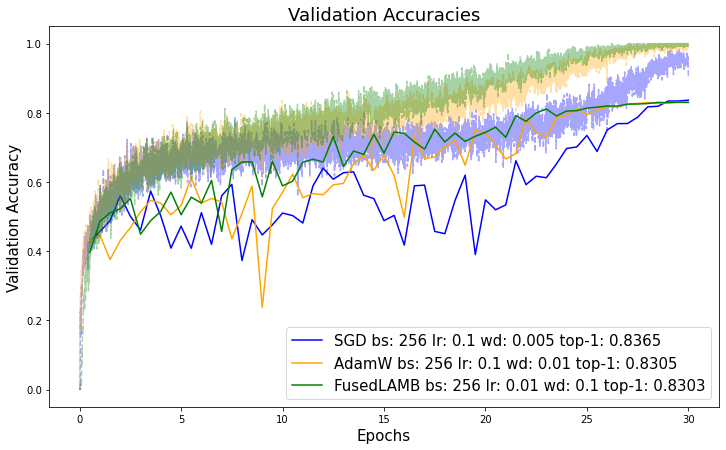

Resnet-18: SGD bs: 256 lr: 0.1 wd: 0.005 top-1: 0.8365 >>> Training complete in: 0:02:10.606692
Resnet-18: AdamW bs: 256 lr: 0.1 wd: 0.01 top-1: 0.8305 >>> Training complete in: 0:02:31.214266
Resnet-18: FusedLAMB bs: 256 lr: 0.01 wd: 0.1 top-1: 0.8303 >>> Training complete in: 0:02:00.424662


In [39]:
jobids=[jobid_sgd[:1], jobid_adamw[:1], jobid_lamb[:1]]
plot_accuracy(jobids)

#### Large Batch

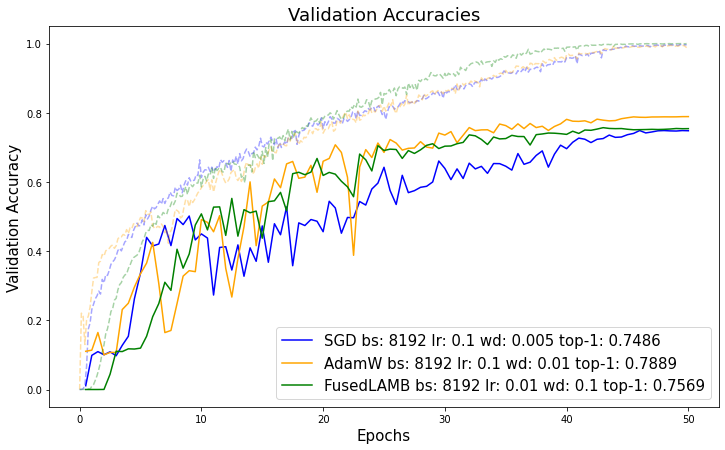

Resnet-18: SGD bs: 8192 lr: 0.1 wd: 0.005 top-1: 0.7486 >>> Training complete in: 0:01:30.652120
Resnet-18: AdamW bs: 8192 lr: 0.1 wd: 0.01 top-1: 0.7889 >>> Training complete in: 0:01:31.498707
Resnet-18: FusedLAMB bs: 8192 lr: 0.01 wd: 0.1 top-1: 0.7569 >>> Training complete in: 0:01:30.301262


In [40]:
jobids=[jobid_sgd[1:], jobid_adamw[1:], jobid_lamb[1:]]
plot_accuracy(jobids)

## TP_opti_4 : Optimiseur *LARS*

Pour finir nous allons essayer un entrainement large batch avec l'optimiseur LARS ou LARC (optimisation apex de LARS)

**TODO** : dans le script `cifar10.py`:
* Remplacer l'optimiseur *LAMB* par l'optimiseur *LARC* :

```python
optimizer = ...

wrapped_optimizer = optimizer
```
par

```python
optimizer = torch.optim.SGD(model.parameters(), args.lr, momentum=args.mom, weight_decay=args.wd)
    
wrapped_optimizer = LARC(optimizer)
```

Il faut maintenant à nouveau trouver la valeur de *learning rate* maximale à donner en paramètre pour cet optimiseur :

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

In [41]:
command = [f'cifar10.py -b 128 -e 10 --findlr --lr 5.', 
           f'cifar10.py -b 4096 -e 20 --findlr --lr 5.']
jobid_lars_lrf = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_lars_lrf = {jobid_lars_lrf}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 10 cpus per task
Submitted batch job 228624
Submitted batch job 228625
jobid_lars_lrf = ['228624', '228625']


In [42]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            228624   gpu_p13 solution  ssos023  R       1:17      1 r10i1n6

 Done!


In [43]:
#jobid_lars_lrf = ['392796', '392797']

#### Small Batch

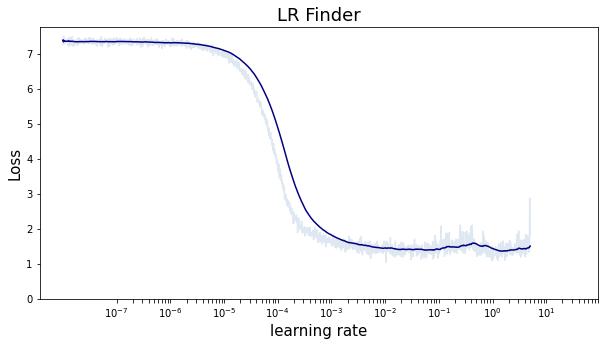

In [44]:
lrfind_plot(jobid_lars_lrf[:1])

#### Large Batch

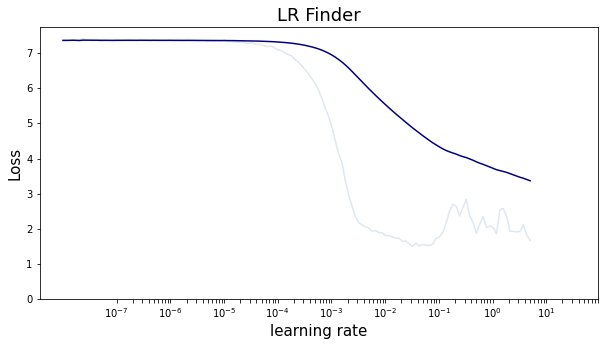

In [45]:
lrfind_plot(jobid_lars_lrf[1:])

Vous pouvez maintenant lancer l'entrainement avec l'optimiseur LARS.

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

**TODO : remplacer XXX par les valeurs maximales de *learning rate* choisies (Small Batch et Large Batch)**

In [46]:
lr_smallb = 1
lr_largeb = 0.5
command = [f'cifar10.py -b 128 -e 30 --wd 5e-3 --lr {lr_smallb}', 
           f'cifar10.py -b 4096 -e 50 --wd 5e-3 --lr {lr_largeb}']
jobid_lars = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_lars = {jobid_lars}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 10 cpus per task
Submitted batch job 228631
Submitted batch job 228633
jobid_lars = ['228631', '228633']


In [47]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            228631   gpu_p13 solution  ssos023  R       3:36      1 r10i1n6

 Done!


In [48]:
#jobid_lars = ['392816', '392820']

Vous pouvez comparer les courbes de *test accuracy* et de *train accuracy* avec les entrainements précédents.

#### Small Batch

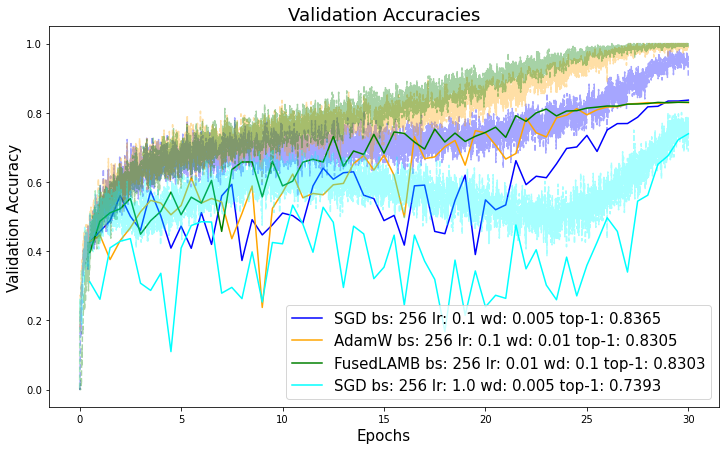

Resnet-18: SGD bs: 256 lr: 0.1 wd: 0.005 top-1: 0.8365 >>> Training complete in: 0:02:10.606692
Resnet-18: AdamW bs: 256 lr: 0.1 wd: 0.01 top-1: 0.8305 >>> Training complete in: 0:02:31.214266
Resnet-18: FusedLAMB bs: 256 lr: 0.01 wd: 0.1 top-1: 0.8303 >>> Training complete in: 0:02:00.424662
Resnet-18: SGD bs: 256 lr: 1.0 wd: 0.005 top-1: 0.7393 >>> Training complete in: 0:03:28.887740


In [49]:
jobids=[jobid_sgd[:1], jobid_adamw[:1], jobid_lamb[:1], jobid_lars[:1]]
plot_accuracy(jobids)

#### Large Batch

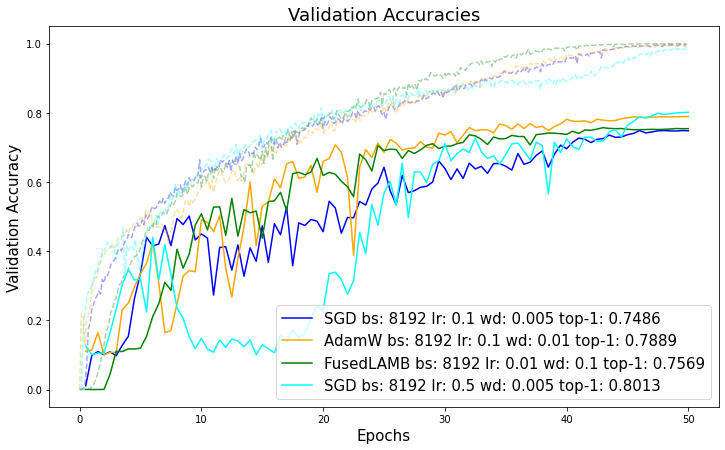

Resnet-18: SGD bs: 8192 lr: 0.1 wd: 0.005 top-1: 0.7486 >>> Training complete in: 0:01:30.652120
Resnet-18: AdamW bs: 8192 lr: 0.1 wd: 0.01 top-1: 0.7889 >>> Training complete in: 0:01:31.498707
Resnet-18: FusedLAMB bs: 8192 lr: 0.01 wd: 0.1 top-1: 0.7569 >>> Training complete in: 0:01:30.301262
Resnet-18: SGD bs: 8192 lr: 0.5 wd: 0.005 top-1: 0.8013 >>> Training complete in: 0:01:34.359305


In [50]:
jobids=[jobid_sgd[1:], jobid_adamw[1:], jobid_lamb[1:], jobid_lars[1:]]
plot_accuracy(jobids)

## &#x2622; ⚠ Bonus expérimental ⚠ &#x2622; 
## TP_opti_5 : Optimiseur *LION* 

Dans cette section bonus, nous allons tester un optimiseur relativement récent : LION.

Il s'agit d'un optimiseur issue de la publication : Symbolic Discovery of Optimization Algorithms, https://arxiv.org/abs/2302.06675

**TODO** : dans le script `cifar10.py`:
* Remplacer l'optimiseur *LARC* par l'optimiseur *LION* :

```python
optimizer = torch.optim.SGD(model.parameters(), args.lr, momentum=args.mom, weight_decay=args.wd)

wrapped_optimizer = LARC(optimizer)
```
par

```python
optimizer = Lion(model.parameters(), lr=args.lr, weight_decay=args.wd)
    
wrapped_optimizer = optimizer
```

Il faut maintenant à nouveau trouver la valeur de *learning rate* maximale à donner en paramètre pour cet optimiseur :

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

In [51]:
command = [f'cifar10_opti_5.py -b 128 -e 10 --findlr --lr 5.', 
           f'cifar10_opti_5.py -b 4096 -e 20 --findlr --lr 5.']
jobid_lion_lrf = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_lion_lrf = {jobid_lion_lrf}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 10 cpus per task
Submitted batch job 228681
Submitted batch job 228682
jobid_lion_lrf = ['228681', '228682']


In [52]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            228681   gpu_p13 solution  ssos023  R       0:50      1 r10i1n6

 Done!


In [53]:
#jobid_lion_lrf = ['221092', '221093']

#### Small Batch

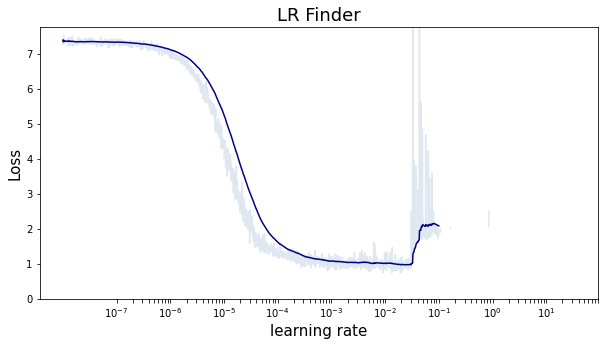

In [54]:
lrfind_plot(jobid_lion_lrf[:1])

#### Large Batch

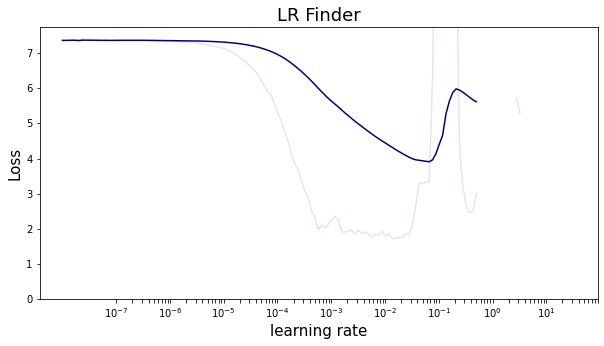

In [55]:
lrfind_plot(jobid_lion_lrf[1:])

**En complément du *learning rate scheduler*, voici quelques indications des auteurs de l'article :**
> *Based on our experience, a suitable learning rate for Lion is typically 3-10x smaller than that for AdamW. Since the effective weight decay is lr * λ, the value of decoupled weight decay λ used for Lion is 3-10x larger than that for AdamW in order to maintain a similar strength.*

Vous pouvez maintenant lancer l'entrainement avec l'optimiseur LION.

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

**TODO : remplacer XXX par les valeurs maximales de *learning rate* choisies (Small Batch et Large Batch). 
Vous devrez aussi définir les valeurs de *weight decay* pour chaque taille de batch.** 

**Pour les relativement petits batchs, vous devriez pouvoir obtenir de bonnes performances en vous servant du learning rate finder et des conseils des auteurs**

**Le cas des larges batchs n'est pas aussi trivial. Lors de nos tests, nous n'avons pas pu identifier des paramètres véritablement plus efficaces.**

**Vous pouvez commencer avec le même *learning rate scheduler* qu'avant mais nous vous invitons vivement à expérimenter des changements dessus.**


**TODO** :  dans le script `cifar10.py`:
* Changer le learning rate scheduler par un CosineAnnealingLR pour lequel le comportement de LION est plus régulier.

```python
scheduler = ...
```
par

```python
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max=N_batch*args.epochs, 
                                                       eta_min=args.lr/5) 
```

In [56]:
lr_smallb = 0.001
lr_largeb = 0.001
wd_smallb = 3e-1
wd_largeb = 3e-1
command = [f'cifar10_opti_5.py -b 128 -e 30 --wd {wd_smallb} --lr {lr_smallb}', 
           f'cifar10_opti_5.py -b 4096 -e 50 --wd {wd_largeb} --lr {lr_largeb}']
jobid_lion = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_lion = {jobid_lion}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 10 cpus per task
Submitted batch job 228705
Submitted batch job 228706
jobid_lion = ['228705', '228706']


In [58]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            228705   gpu_p13 solution  ssos023  R       3:03      1 r10i6n2

 Done!


In [57]:
#jobid_lion = ['228705', '228706']

Vous pouvez comparer les courbes de *test accuracy* et de *train accuracy* avec les entrainements précédents.

#### Small Batch

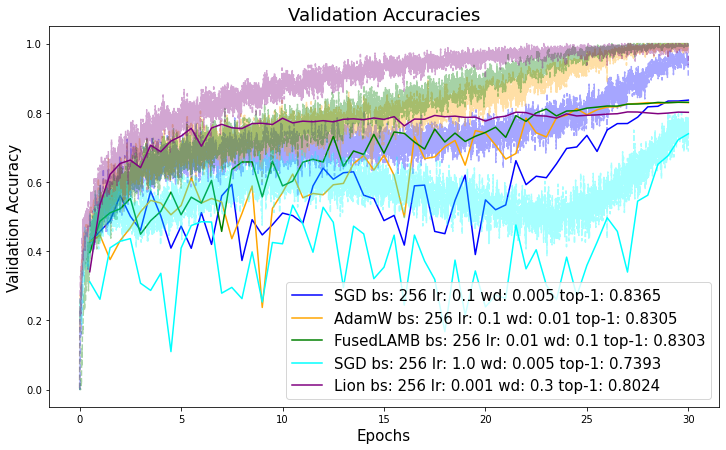

Resnet-18: SGD bs: 256 lr: 0.1 wd: 0.005 top-1: 0.8365 >>> Training complete in: 0:02:10.606692
Resnet-18: AdamW bs: 256 lr: 0.1 wd: 0.01 top-1: 0.8305 >>> Training complete in: 0:02:31.214266
Resnet-18: FusedLAMB bs: 256 lr: 0.01 wd: 0.1 top-1: 0.8303 >>> Training complete in: 0:02:00.424662
Resnet-18: SGD bs: 256 lr: 1.0 wd: 0.005 top-1: 0.7393 >>> Training complete in: 0:03:28.887740
Resnet-18: Lion bs: 256 lr: 0.001 wd: 0.3 top-1: 0.8024 >>> Training complete in: 0:02:27.356441


In [59]:
jobids=[jobid_sgd[:1], jobid_adamw[:1], jobid_lamb[:1], jobid_lars[:1], jobid_lion[:1]]
plot_accuracy(jobids)

#### Large Batch

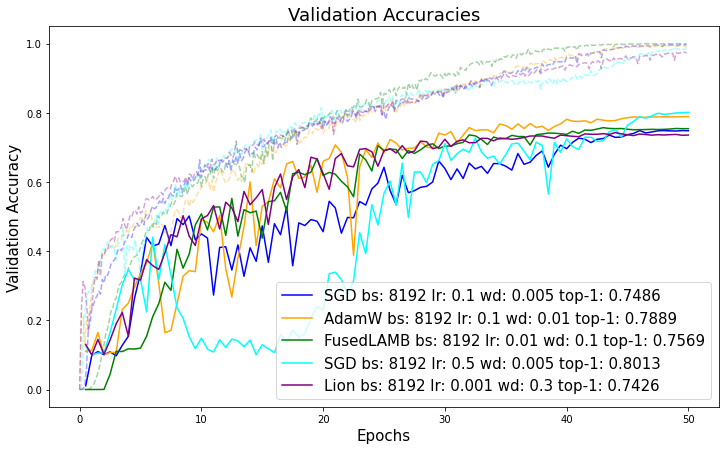

Resnet-18: SGD bs: 8192 lr: 0.1 wd: 0.005 top-1: 0.7486 >>> Training complete in: 0:01:30.652120
Resnet-18: AdamW bs: 8192 lr: 0.1 wd: 0.01 top-1: 0.7889 >>> Training complete in: 0:01:31.498707
Resnet-18: FusedLAMB bs: 8192 lr: 0.01 wd: 0.1 top-1: 0.7569 >>> Training complete in: 0:01:30.301262
Resnet-18: SGD bs: 8192 lr: 0.5 wd: 0.005 top-1: 0.8013 >>> Training complete in: 0:01:34.359305
Resnet-18: Lion bs: 8192 lr: 0.001 wd: 0.3 top-1: 0.7426 >>> Training complete in: 0:01:34.619481


In [61]:
jobids=[jobid_sgd[1:], jobid_adamw[1:], jobid_lamb[1:], jobid_lars[1:], jobid_lion[1:]]
plot_accuracy(jobids)

--------------

## Annexe

Avec l'*optimizer* de votre choix (Il faudra modifier le code en fonction) :

Vous pouvez faire d'autres tests en jouant sur les différents paramètres :
* Nombre d'epoch
* La valeur du *weight decay*
* La valeur du *learning rate*
* La taille de batch. Attention : **sur 2 GPU**, donc la taille de *batch* sera **multipliée par 2**.

In [ ]:
n_epoch = 
weight_decay = 
lr = 
batch_size = 
command = f'cifar10.py -b {batch_size} -e {n_epoch} --wd {weight_decay} --lr {lr}'

#### LR finder (Optionnel)

In [ ]:
display_slurm_queue(name)

In [ ]:
#jobid_test_lrf =

In [ ]:
lrfind_plot(jobid_test_lrf)

#### Apprentissage

In [ ]:
display_slurm_queue(name)

In [ ]:
#jobid_test = ['428']

In [ ]:
plot_accuracy(jobid_test)

--------------